In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

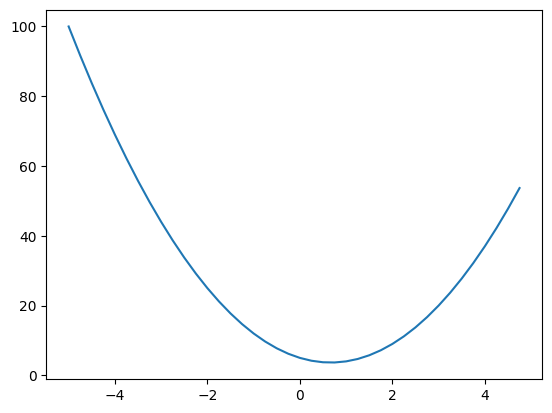

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000000001
x = -3.0
(f(x+h) - f(x))/h

-22.000001820288162

In [6]:
# lets get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [42]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        #assert(isinstance(other, (int, float)), "only supporting int/float powers for now")
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):
        return self * other

    def __radd__(self, other):
        return self + other

    def __truediv__(self, other):
        return self * other**-1

    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.grad * out.data
        out._backward = _backward
        
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
a = Value(2.0)
b = Value(4.0)
a / b
a - b

Value(data=-2.0)

In [10]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label='L'

In [11]:
d._op

'+'

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, 
                 label=f"{n.label} | data {n.data:.4f} | grad {n.grad:.4f}", 
                 shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

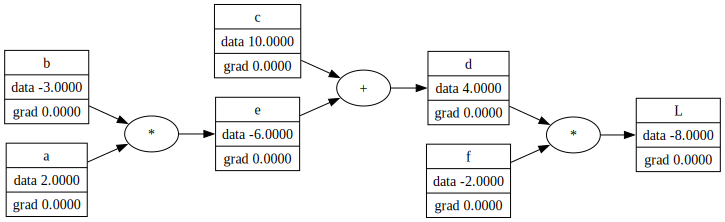

In [13]:
draw_dot(L)

In [14]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2

In [15]:
def lol():
    h = 0.0001
    
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data

    a = Value(2.0+h, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label = 'e'
    d = e+c; d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L2 = L.data

    print((L2-L1)/h)

lol()

6.000000000021544


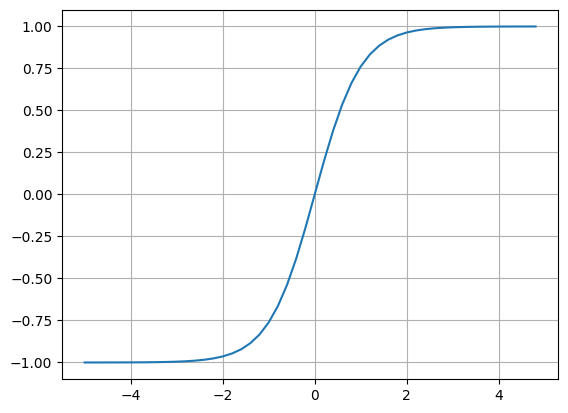

In [16]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2)))
plt.grid()

In [17]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

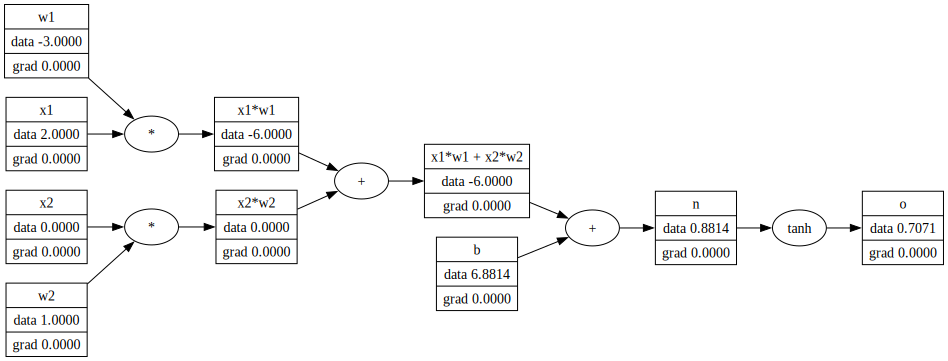

In [18]:
draw_dot(o)

In [19]:
o.backward()

In [20]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)

for node in reversed(topo):
    node._backward()

In [21]:
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [22]:
o.grad = 1.0

In [23]:
o._backward()

In [24]:
n._backward()

In [25]:
b._backward()

In [26]:
x1w1x2w2._backward()

In [27]:
x1w1._backward()
x2w2._backward()

In [28]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [29]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [30]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [31]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [32]:
n.grad = 0.5

In [33]:
o.grad = 1.0

In [34]:
1 - o.data**2

0.4999999999999999

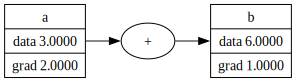

In [35]:
a = Value(3.0, label='a')
b = a + a; b.label = 'b'
b.backward()
draw_dot(b)

In [36]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e-1)/(e+1)
# ----
o.label = 'o'
o.backward()

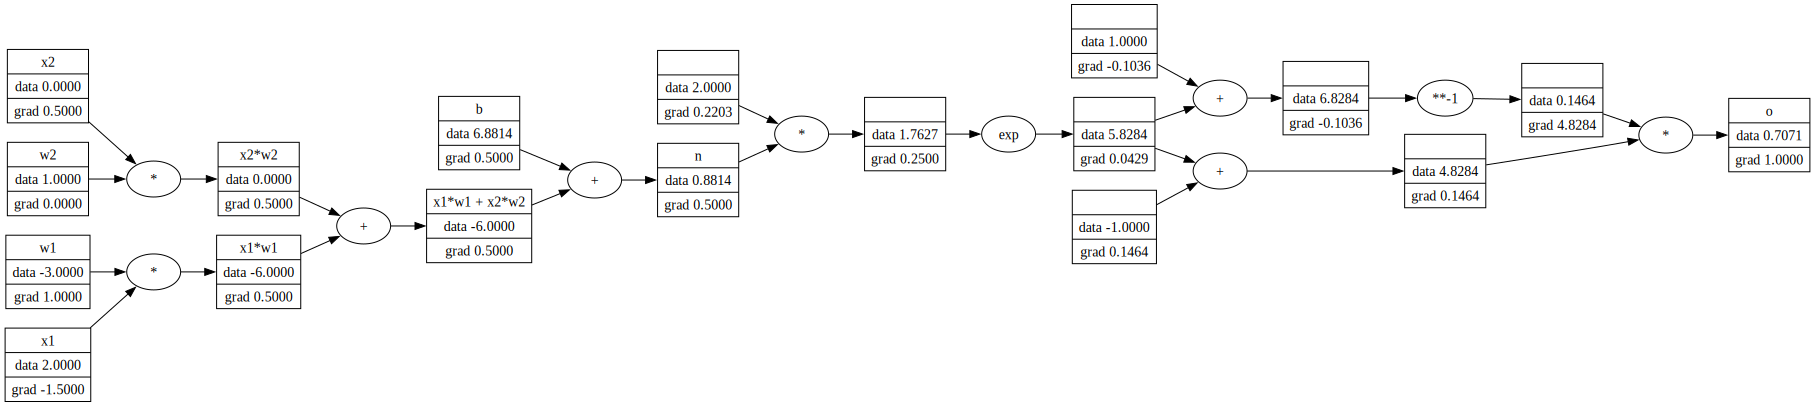

In [37]:
draw_dot(o)

In [38]:
import torch

x1 = torch.Tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.Tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();  w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [66]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

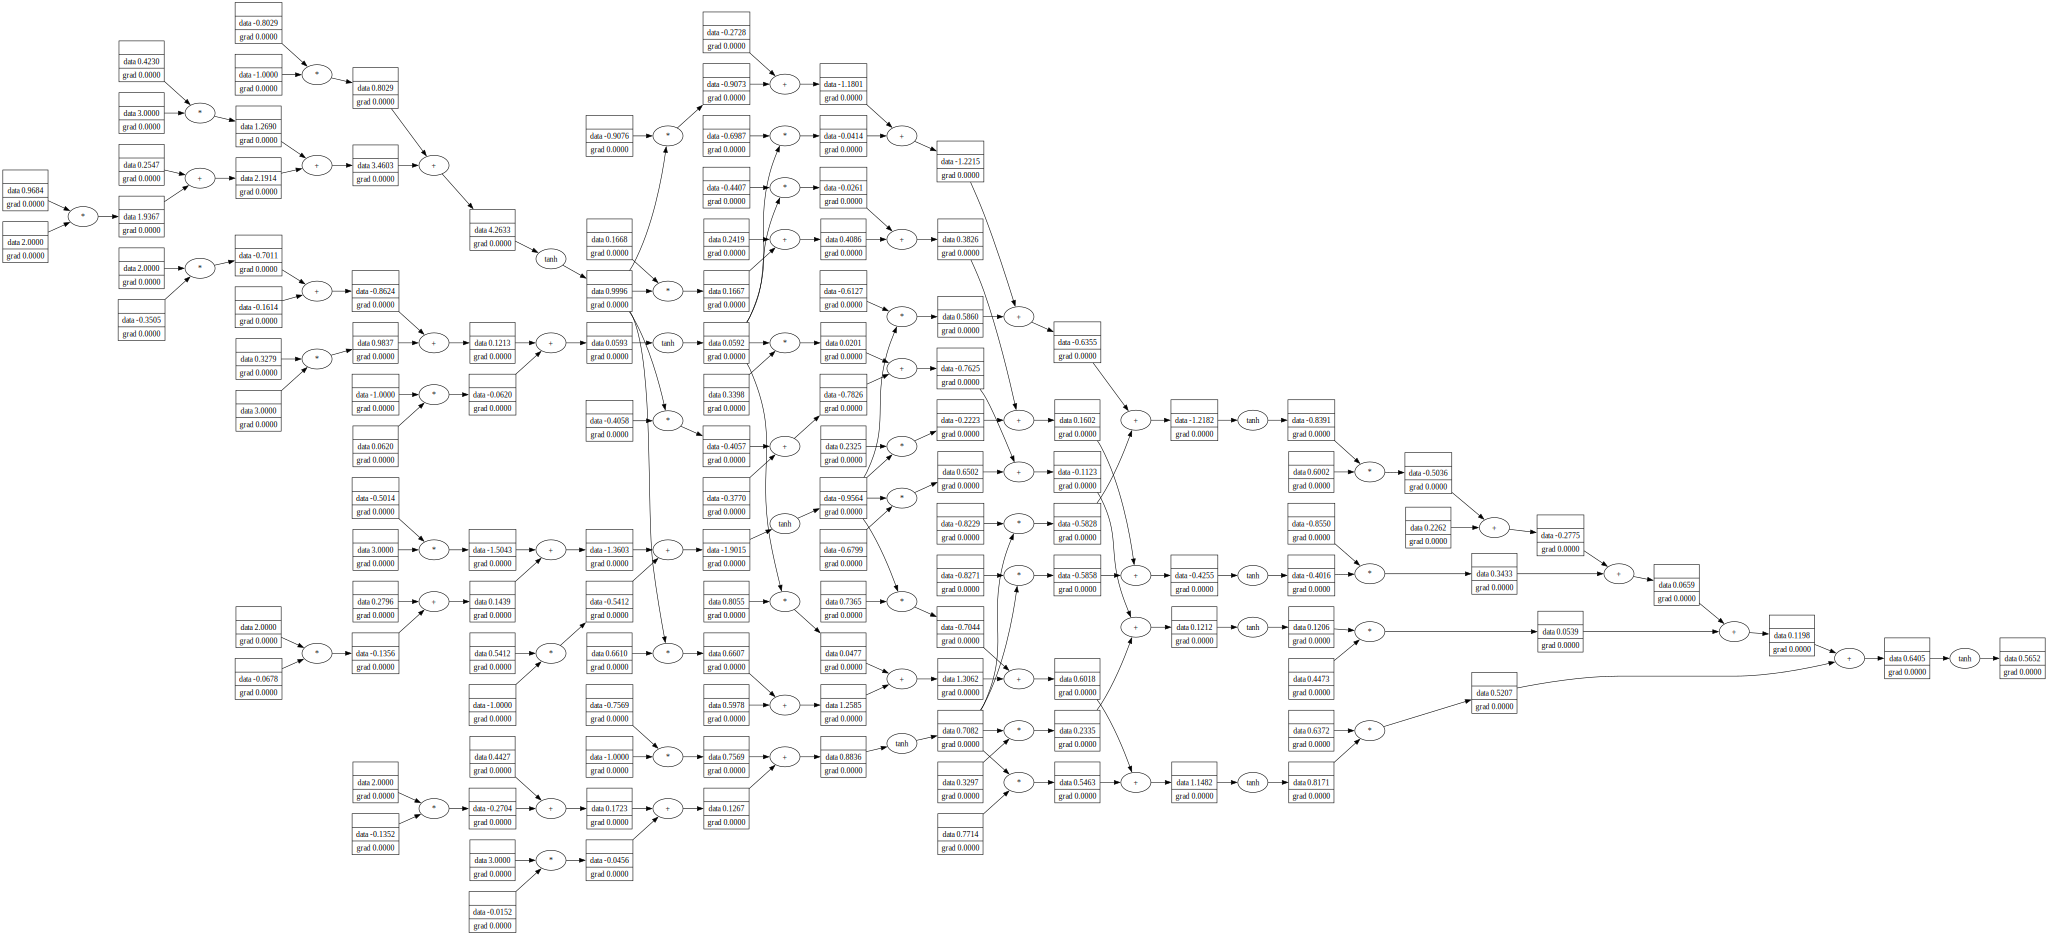

In [52]:
draw_dot(n(x))

In [67]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.9832742377341573)

In [68]:
n.parameters()

[Value(data=0.23383772612433673),
 Value(data=0.935155069167316),
 Value(data=-0.740637783783064),
 Value(data=0.6784323034180333),
 Value(data=0.09098641272814967),
 Value(data=-0.9501052370156624),
 Value(data=-0.06808817472312878),
 Value(data=0.16359400366128551),
 Value(data=-0.708290503713205),
 Value(data=0.5295191410547464),
 Value(data=-0.5205234082856256),
 Value(data=-0.5949734935326143),
 Value(data=0.969378915834793),
 Value(data=-0.5855640174600483),
 Value(data=0.41509234325526356),
 Value(data=0.7947824016316756),
 Value(data=0.2020895138466292),
 Value(data=0.5706525709768697),
 Value(data=-0.8616880951370529),
 Value(data=-0.6611855995083591),
 Value(data=0.10639089897168308),
 Value(data=0.2665525626117242),
 Value(data=-0.6872517766696844),
 Value(data=0.3118933906941632),
 Value(data=-0.29565780859588786),
 Value(data=0.973979962003217),
 Value(data=0.27540144571871017),
 Value(data=0.8547203366258189),
 Value(data=0.4708789021235493),
 Value(data=-0.34432153837194

In [76]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

In [92]:
ypred = [n(x) for x in xs]
ypred

[Value(data=0.8379750481944044),
 Value(data=-0.9683527429706202),
 Value(data=-0.7525593164341212),
 Value(data=-0.5125873013787194)]

In [70]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.029568086016972)

In [93]:
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.3764008700607957)

In [89]:
loss.backward()

In [72]:
n.layers[0].neurons[0].w[0].grad

1.015001760169553

In [73]:
n.layers[0].neurons[0].w[0].data

0.23383772612433673

In [90]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [91]:
n.layers[0].neurons[0].w[0].data

-0.07656623005249527

In [103]:
n = MLP(3, [4, 4, 1])

In [143]:
for k in range(50):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))

    # zero grad
    for p in n.parameters():
        p.grad = 0.0

    # backward pass
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    print(k, loss.data)

0 0.00012341103233110928
1 0.0001233451510056062
2 0.0001232793383164091
3 0.00012321359415714078
4 0.00012314791842163748
5 0.00012308231100395452
6 0.0001230167717983622
7 0.0001229513006993531
8 0.00012288589760163927
9 0.00012282056240013562
10 0.0001227552949899907
11 0.00012269009526654837
12 0.00012262496312538923
13 0.00012255989846228344
14 0.0001224949011732354
15 0.0001224299711544512
16 0.0001223651083023502
17 0.0001223003125135677
18 0.00012223558368494532
19 0.0001221709217135436
20 0.00012210632649662252
21 0.0001220417979316547
22 0.00012197733591632796
23 0.00012191294034853275
24 0.00012184861112637162
25 0.0001217843481481474
26 0.00012172015131237845
27 0.0001216560205177866
28 0.00012159195566329498
29 0.00012152795664803923
30 0.00012146402337135384
31 0.00012140015573278353
32 0.00012133635363207159
33 0.0001212726169691678
34 0.00012120894564422672
35 0.00012114533955759304
36 0.00012108179860983235
37 0.00012101832270169441
38 0.00012095491173414269
39 0.00012